# finding time for the grid cells 

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from shapely.geometry import LineString, Point
import geopandas as gpd
from scipy.interpolate import interp1d

In [3]:
raw = pd.read_csv("/home/s232713/data/trip_time.csv")
counts = (
    raw.groupby("Interval ID")["INDIVID"]
       .nunique()
       .sort_values(ascending=False)
)

print(counts)

problematic = counts[counts > 1]
print("Intervals with >1 INDIVID:")
print(problematic)



Interval ID
714232    1
265109    1
266118    1
266360    1
266417    1
         ..
268396    1
268288    1
268286    1
268171    1
268106    1
Name: INDIVID, Length: 2008, dtype: int64
Intervals with >1 INDIVID:
Series([], Name: INDIVID, dtype: int64)


In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from shapely.geometry import LineString, Point
import geopandas as gpd

clean = pd.read_csv("/home/s232713/data/clean_points.csv", sep=';')
clean["Interval ID"] = clean["Interval ID"].astype(int)

raw = pd.read_csv("/home/s232713/data/trip_time.csv")
raw["Timestamp"] = pd.to_datetime(raw["Timestamp"])
raw["Interval ID"] = raw["Interval ID"].astype(int)

aligned = []

for interval in tqdm(clean["Interval ID"].unique(), desc="Interpolating with LineString.project"):

    cseg = clean[clean["Interval ID"] == interval].copy()
    rseg = raw[raw["Interval ID"] == interval].copy()

    if len(rseg) < 2:
        continue

    # Convert raw points to GeoDataFrame (for line construction) 
    r_gdf = gpd.GeoDataFrame(
        rseg,
        geometry=gpd.points_from_xy(rseg["Longitude"], rseg["Latitude"]),
        crs="EPSG:4326"
    ).to_crs(3857)

    # Build raw trajectory LineString 
    line_raw = LineString(r_gdf.geometry.tolist())

    # Raw distances along the line
    d_raw = np.array([line_raw.project(pt) for pt in r_gdf.geometry])
    t_raw = (rseg["Timestamp"]
             .astype("int64")
             .to_numpy() / 1e9)  # seconds as float

    # Sort by distance on the line for monotonicity
    sort_idx = np.argsort(d_raw)
    d_raw_sorted = d_raw[sort_idx]
    t_raw_sorted = t_raw[sort_idx]

    # Clean points in the same CRS
    c_gdf = gpd.GeoDataFrame(
        cseg,
        geometry=gpd.points_from_xy(cseg["Longitude"], cseg["Latitude"]),
        crs="EPSG:4326"
    ).to_crs(3857)

    # Distance of each clean point along the raw line
    d_clean = np.array([line_raw.project(pt) for pt in c_gdf.geometry])

    # clip to avoid extrapolation at the edges
    d_clean_clipped = np.clip(d_clean, d_raw_sorted.min(), d_raw_sorted.max())

    # Temporal interpolation on the projected distances
    t_clean = np.interp(d_clean_clipped, d_raw_sorted, t_raw_sorted)


    # Assign timestamps back 
    cseg["Timestamp"] = pd.to_datetime(t_clean, unit="s")
    cseg["Milliseconds"] = cseg["Timestamp"].astype("int64") // 1_000_000
    cseg["INDIVID"] = rseg.iloc[0]["INDIVID"]
    cseg["Activity_concat"] = rseg.iloc[0]["Activity_concat"]

    aligned.append(cseg)

clean_interp = pd.concat(aligned, ignore_index=True)

clean_interp['Timestamp'] = clean_interp['Timestamp'].dt.round('s') # Rounding to the nearest second

print(clean_interp.head())
print(clean_interp.shape)


Interpolating with LineString.project: 100%|██████████| 14560/14560 [03:55<00:00, 61.84it/s] 


   Interval ID  Latitude  Longitude           Timestamp   Milliseconds  \
0       629206  55.68503   12.53529 2024-06-04 14:26:27  1717511187406   
1       629206  55.68481   12.53499 2024-06-04 14:27:00  1717511220299   
2       629206  55.68455   12.53484 2024-06-04 14:27:23  1717511242744   
3       629206  55.68434   12.53450 2024-06-04 14:27:43  1717511262883   
4       629206  55.68407   12.53436 2024-06-04 14:27:57  1717511277262   

    INDIVID Activity_concat  
0  MMM24201            Foot  
1  MMM24201            Foot  
2  MMM24201            Foot  
3  MMM24201            Foot  
4  MMM24201            Foot  
(53599, 7)


In [ ]:
import pandas as pd
# exposure_gdf = pd.read_csv('/home/s232713/data/grid_time.csv') # mine
merged_data = pd.read_pickle('/home/s232713/data/final_merged_data.pkl') # big one 
raw = pd.read_csv("/home/s232713/data/trip_time.csv") # raw with times

intervals = clean_interp['Interval ID'].unique()

for interval in intervals:
    print(f'-------ID: {interval}-------')
    
    print(f'time range interval in interval {interval}', clean_interp[clean_interp['Interval ID'] == interval]['Timestamp'].min(), clean_interp[clean_interp['Interval ID'] == interval]['Timestamp'].max())

    print(f'time range raw intervals {interval}', raw[raw['Interval ID'] == interval]['Timestamp'].min(), raw[raw['Interval ID'] == interval]['Timestamp'].max())

    print(
        f'time range diary {interval}:', 
        pd.to_datetime(merged_data[merged_data['Interval ID'] == interval]['Start Time_x']).iloc[0], 
        pd.to_datetime(merged_data[merged_data['Interval ID'] == interval]['End Time_x']).iloc[0]
    )

-------ID: 629206-------
time range interval in cells 629206 2024-06-04 14:26:27 2024-06-04 14:39:54
time range raw intervals 629206 2024-06-04 14:26:00 2024-06-04 14:39:54
time range diary 629206: 2024-06-04 14:26:00 2024-06-04 14:39:54
-------ID: 629515-------
time range interval in cells 629515 2024-06-04 16:07:06 2024-06-04 16:15:33
time range raw intervals 629515 2024-06-04 16:07:06 2024-06-04 16:15:34
time range diary 629515: 2024-06-04 16:07:06 2024-06-04 16:15:34
-------ID: 629517-------
time range interval in cells 629517 2024-06-04 16:36:22 2024-06-04 16:38:12
time range raw intervals 629517 2024-06-04 16:36:21 2024-06-04 16:38:12
time range diary 629517: 2024-06-04 16:36:21 2024-06-04 16:38:12
-------ID: 629927-------
time range interval in cells 629927 2024-06-04 19:20:44 2024-06-04 19:27:48
time range raw intervals 629927 2024-06-04 19:20:38 2024-06-04 19:28:02
time range diary 629927: 2024-06-04 19:20:38 2024-06-04 19:28:02
-------ID: 687276-------
time range interval in 

clean points shape: (1923328, 3)
number of intervals 14560
calculated raw shape: (1527912, 11)
number of intervals 2008
number of individuals 110


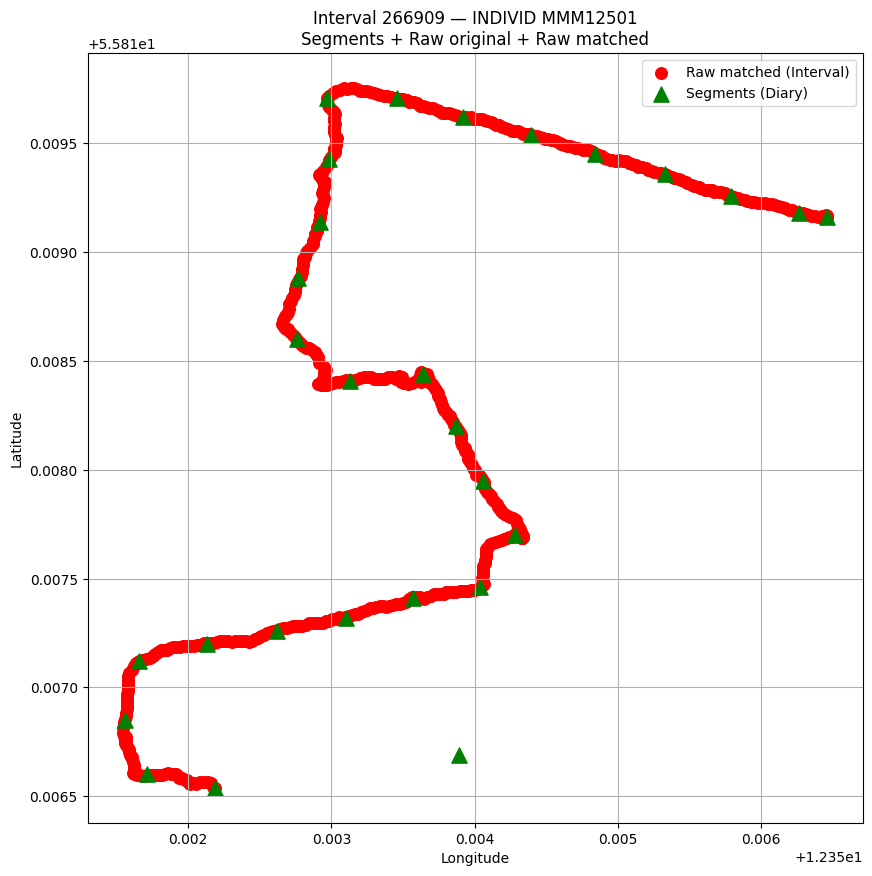

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

interval = 266909
indiv = "MMM12501"

# 1. LOAD segments
#segments = pd.read_csv(
#    "/run/user/1036/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/Public/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/Xing/GPS/Final/segments.csv"
#)
# seg_int = segments[(segments["Interval ID"] == interval) & (segments["INDIVID"] == indiv)]
segments = pd.read_csv('/home/s232713/data/clean_points.csv', sep=';')
seg_int = segments[(segments["Interval ID"] == interval)]

print("clean points shape:", segments.shape)
print('number of intervals', segments['Interval ID'].nunique())
# print('number of individuals', segments['INDIVID'].nunique())

# 2. LOAD my matched RAW (quelle del conditional_join)
raw_my = raw[(raw["Interval ID"] == interval) ]

print("calculated raw shape:", raw.shape)
print('number of intervals', raw['Interval ID'].nunique())
print('number of individuals', raw['INDIVID'].nunique())


plt.figure(figsize=(10,10))

# RAW ORIGINAL (grey)
# plt.scatter(raw_original["Longitude"], raw_original["Latitude"],
#            c="grey", alpha=0.3, s=40, label="Raw original (all for INDIVID)")

# RAW matched (red)
plt.scatter(raw_my["Longitude"], raw_my["Latitude"],
           c="red", s=70, label="Raw matched (Interval)")

# Segments (green triangles)
plt.scatter(seg_int["Longitude"], seg_int["Latitude"],
            c="green", marker="^", s=120, label="Segments (Diary)")

plt.title(f"Interval {interval} — INDIVID {indiv}\nSegments + Raw original + Raw matched")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()




In [7]:
sel = raw[raw["Interval ID"] == interval]
print("INDIVID in this interval:", sel["INDIVID"].unique())
print(sel.groupby("INDIVID")[["Latitude","Longitude"]].agg(["min","max"]))


INDIVID in this interval: ['MMM12501']
           Latitude             Longitude           
                min        max        min        max
INDIVID                                             
MMM12501  55.816539  55.819755  12.351544  12.356458


In [8]:
import pandas as pd

segments = pd.read_csv(
    "/run/user/1036/gvfs/smb-share:server=ait-pdfs.win.dtu.dk,share=department/Man/Public/4233-81647-eMOTIONAL-Cities/5 Data/ECDTU/Xing/GPS/Final/segments.csv"
)

# How many individuals per interval?
counts = segments.groupby("Interval ID")["INDIVID"].nunique().sort_values(ascending=False)

# Show intervals that are shared across multiple individuals
problematic = counts[counts > 1]
print("Intervals with more than one INDIVID:")
print(problematic)


Intervals with more than one INDIVID:
Series([], Name: INDIVID, dtype: int64)


In [ ]:
# check total loss in seconds per interval
exposure = clean_interp.copy()
merged = merged_data.copy()

print('loss diary vs calculated')

rows = []

for interval in exposure['Interval ID'].unique():
    # ranges from exposure
    exp_min = pd.to_datetime(exposure[exposure['Interval ID'] == interval]['Timestamp'].min())
    exp_max = pd.to_datetime(exposure[exposure['Interval ID'] == interval]['Timestamp'].max())

    # ranges from merged dataset
    mrg = merged[merged['Interval ID'] == interval].iloc[0]
    mrg_min = pd.to_datetime(mrg['Start Time_x'])
    mrg_max = pd.to_datetime(mrg['End Time_x'])

    # loss at start and end
    loss_start = (mrg_min - exp_min).total_seconds()
    loss_end = (exp_max - mrg_max).total_seconds()

    # total absolute loss for the interval
    total_loss = abs(loss_start) + abs(loss_end)

    rows.append([interval, loss_start, loss_end, total_loss])

df_loss_diary_calc = pd.DataFrame(rows, columns=['Interval ID', 'Loss start (s)', 'Loss end (s)', 'Total loss (s)'])

print(df_loss_diary_calc.describe())

print(100*'-')
print('loss raw vs diary')

rows = []

for interval in exposure['Interval ID'].unique():
    # ranges from raw
    exp_min = pd.to_datetime(raw[raw['Interval ID'] == interval]['Timestamp'].min())
    exp_max = pd.to_datetime(raw[raw['Interval ID'] == interval]['Timestamp'].max())

    # ranges from merged dataset
    mrg = merged[merged['Interval ID'] == interval].iloc[0]
    mrg_min = pd.to_datetime(mrg['Start Time_x'])
    mrg_max = pd.to_datetime(mrg['End Time_x'])

    # loss at start and end
    loss_start = (mrg_min - exp_min).total_seconds()
    loss_end = (exp_max - mrg_max).total_seconds()

    # total absolute loss for the interval
    total_loss = abs(loss_start) + abs(loss_end)

    rows.append([interval, loss_start, loss_end, total_loss])

df_loss_raw_diary = pd.DataFrame(rows, columns=['Interval ID', 'Loss start (s)', 'Loss end (s)', 'Total loss (s)'])

print(df_loss_raw_diary.describe())

print(100*'-')
print('loss raw vs calculated')

rows = []

for interval in exposure['Interval ID'].unique():
    # ranges from calculated
    exp_min = pd.to_datetime(exposure[exposure['Interval ID'] == interval]['Timestamp'].min())
    exp_max = pd.to_datetime(exposure[exposure['Interval ID'] == interval]['Timestamp'].max())

    # ranges raw
    mrg_min = pd.to_datetime(raw[raw['Interval ID'] == interval]['Timestamp'].min())
    mrg_max = pd.to_datetime(raw[raw['Interval ID'] == interval]['Timestamp'].max())

    # loss at start and end
    loss_start = (mrg_min - exp_min).total_seconds()
    loss_end = (exp_max - mrg_max).total_seconds()

    # total absolute loss for the interval
    total_loss = abs(loss_start) + abs(loss_end)

    rows.append([interval, loss_start, loss_end, total_loss])

df_loss_raw_calc = pd.DataFrame(rows, columns=['Interval ID', 'Loss start (s)', 'Loss end (s)', 'Total loss (s)'])

print(df_loss_raw_calc.describe())

loss diary vs calculated
         Interval ID  Loss start (s)  Loss end (s)  Total loss (s)
count    2004.000000     2004.000000   2004.000000     2004.000000
mean   481187.998503      -20.347305    -19.864770       40.212076
std    135406.203146      252.187896    203.699524      326.968019
min    265109.000000    -6631.000000  -5634.000000        0.000000
25%    356089.750000       -1.000000     -4.000000        0.000000
50%    470458.500000        0.000000      0.000000        1.000000
75%    608453.250000        0.000000      0.000000       12.000000
max    714232.000000        0.000000      0.000000     6661.000000
----------------------------------------------------------------------------------------------------
loss raw vs diary


         Interval ID  Loss start (s)  Loss end (s)  Total loss (s)
count    2004.000000     2004.000000   2004.000000     2004.000000
mean   481187.998503       -7.452096     -7.122255       14.574351
std    135406.203146      158.631357    133.731154      207.254036
min    265109.000000    -6521.000000  -3987.000000        0.000000
25%    356089.750000        0.000000      0.000000        0.000000
50%    470458.500000        0.000000      0.000000        0.000000
75%    608453.250000        0.000000      0.000000        0.000000
max    714232.000000        0.000000      0.000000     6521.000000
----------------------------------------------------------------------------------------------------
loss raw vs loss calculated
         Interval ID  Loss start (s)  Loss end (s)  Total loss (s)
count    2004.000000     2004.000000   2004.000000     2004.000000
mean   481187.998503      -12.895210    -12.742515       25.637725
std    135406.203146      196.389159    153.573076      253.316576


In [10]:
print('top 10 loss diary vs calculated\n', df_loss_diary_calc.sort_values('Total loss (s)', ascending=False).head(10))

print('top 10 loss raw vs diary\n', df_loss_raw_diary.sort_values('Total loss (s)', ascending=False).head(10))

print('top 10 loss raw vs calculated\n', df_loss_raw_calc.sort_values('Total loss (s)', ascending=False).head(10))


top 10 loss diary vs calculated
       Interval ID  Loss start (s)  Loss end (s)  Total loss (s)
1304       536469         -6631.0         -30.0          6661.0
1201       574542         -6521.0         -26.0          6547.0
1794       627662          -214.0       -5634.0          5848.0
654        404463         -4880.0         -50.0          4930.0
1393       597202             0.0       -3987.0          3987.0
1524       587738             0.0       -3238.0          3238.0
837        387795          -209.0       -2973.0          3182.0
761        399424         -2415.0           0.0          2415.0
554        381197             0.0       -2319.0          2319.0
1919       701368             0.0       -2130.0          2130.0
top 10 loss raw vs diary
       Interval ID  Loss start (s)  Loss end (s)  Total loss (s)
1201       574542         -6521.0           0.0          6521.0
1393       597202             0.0       -3987.0          3987.0
1524       587738             0.0       -3232

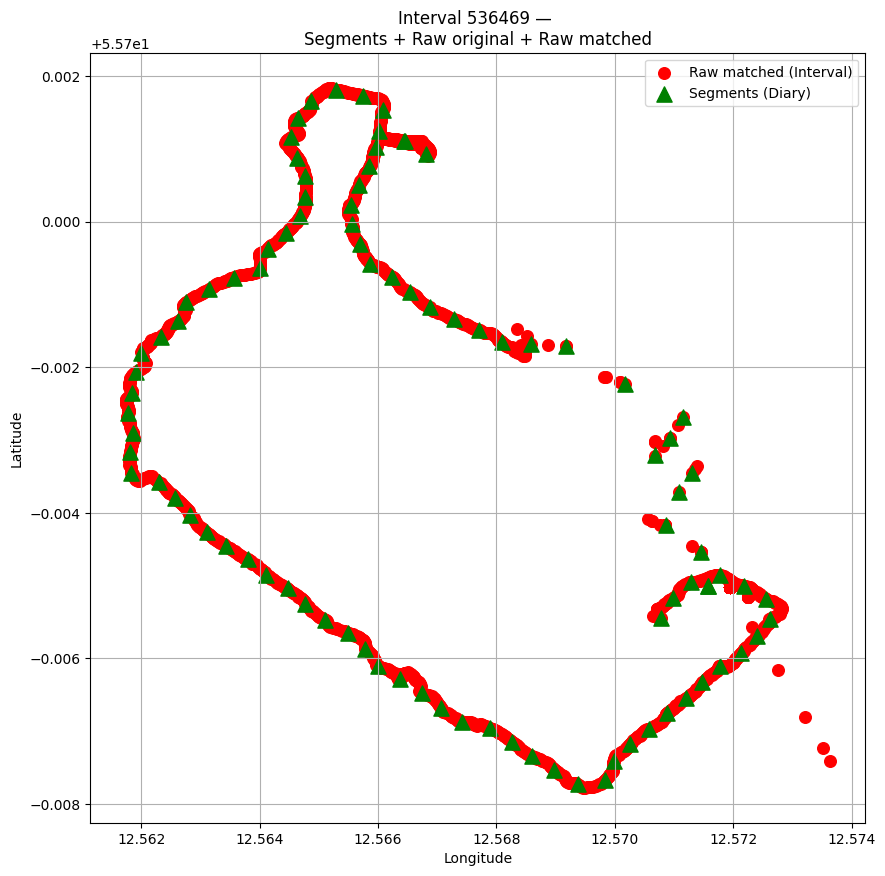

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

interval = 536469

segments = pd.read_csv('/home/s232713/data/clean_points.csv', sep=';')
seg_int = segments[(segments["Interval ID"] == interval)]

# print('number of individuals', segments['INDIVID'].nunique())

raw_my = raw[(raw["Interval ID"] == interval) ]

plt.figure(figsize=(10,10))

plt.scatter(raw_my["Longitude"], raw_my["Latitude"],
           c="red", s=70, label="Raw matched (Interval)")

# Segments (green triangles)
plt.scatter(seg_int["Longitude"], seg_int["Latitude"],
            c="green", marker="^", s=120, label="Segments (Diary)")

plt.title(f"Interval {interval} — \nSegments + Raw original + Raw matched")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
problematic = clean_interp[clean_interp['Interval ID'] == interval]
print(problematic['Timestamp'].min(), problematic['Timestamp'].max())

problematic = merged_data[merged_data['Interval ID'] == interval]
print(problematic['Start Time_x'] , problematic['End Time_x'])

2024-04-26 07:53:31 2024-04-26 08:29:44
8739   2024-04-26 06:03:00
Name: Start Time_x, dtype: datetime64[ns] 8739   2024-04-26 08:30:14
Name: End Time_x, dtype: datetime64[ns]


In [13]:
# eliminate the problematic intervsal > loss total
threshold = 300

bad_1 = df_loss_diary_calc.loc[df_loss_diary_calc["Total loss (s)"] > threshold, "Interval ID"]
bad_2 = df_loss_raw_diary.loc[df_loss_raw_diary["Total loss (s)"] > threshold, "Interval ID"]
bad_3 = df_loss_raw_calc.loc[df_loss_raw_calc["Total loss (s)"] > threshold, "Interval ID"]

bad_ids = set(bad_1).union(set(bad_2)).union(set(bad_3))

print("Numero totale di intervalli problematici:", len(bad_ids))

clean_interp2 = clean_interp[~clean_interp['Interval ID'].isin(bad_ids)]

clean_loss_diary_calc = df_loss_diary_calc[~df_loss_diary_calc["Interval ID"].isin(bad_ids)]
clean_loss_diary_calc = pd.DataFrame(clean_loss_diary_calc)
clean_loss_raw_diary = df_loss_raw_diary[~df_loss_raw_diary["Interval ID"].isin(bad_ids)]
clean_loss_raw_diary = pd.DataFrame(clean_loss_raw_diary)
clean_loss_raw_calc = df_loss_raw_calc[~df_loss_raw_calc["Interval ID"].isin(bad_ids)]
clean_loss_raw_calc = pd.DataFrame(clean_loss_raw_calc)

print('cleaned loss diary vs calculated')
print(clean_loss_diary_calc.describe())
print('cleaned loss raw vs diary')
print(clean_loss_raw_diary.describe())
print('cleaned loss raw vs calculated')
print(clean_loss_raw_calc.describe())

print(10*'--')
print(clean_interp.shape)
print('number of intervals before cleaning: ', clean_interp['Interval ID'].nunique())
print('number of individual before celaning: ', clean_interp['INDIVID'].nunique())
print(clean_interp2.shape)
print('number of intervals after cleaning: ', clean_interp2['Interval ID'].nunique())
print('number of individual after celaning: ', clean_interp2['INDIVID'].nunique())


Numero totale di intervalli problematici: 31
cleaned loss diary vs calculated
         Interval ID  Loss start (s)  Loss end (s)  Total loss (s)
count    1973.000000     1973.000000   1973.000000     1973.000000
mean   480238.974658       -5.424734     -6.722250       12.146984
std    135258.075477       21.374997     20.721174       30.120123
min    265109.000000     -263.000000   -278.000000        0.000000
25%    355609.000000       -1.000000     -4.000000        0.000000
50%    470200.000000        0.000000      0.000000        1.000000
75%    608451.000000        0.000000      0.000000       11.000000
max    714232.000000        0.000000      0.000000      282.000000
cleaned loss raw vs diary
         Interval ID  Loss start (s)  Loss end (s)  Total loss (s)
count    1973.000000     1973.000000   1973.000000     1973.000000
mean   480238.974658       -1.289914     -0.616827        1.906741
std    135258.075477       12.345232      9.185444       15.429530
min    265109.000000     

In [14]:
import pandas as pd
import numpy as np
from shapely.geometry import LineString, Point
import geopandas as gpd
from tqdm import tqdm

# interp = clean_interp.copy()
interp = clean_interp2.copy()

hexes = gpd.read_file("/home/s232713/data/grid_data/cph_hexgrid.geojson")
hexes_3857 = hexes.to_crs(3857)

clean_gdf = gpd.GeoDataFrame(
    interp,
    geometry=gpd.points_from_xy(interp["Longitude"], interp["Latitude"]),
    crs="EPSG:4326"
).to_crs(3857)

lines = (
    clean_gdf.sort_values(["INDIVID", "Interval ID", "Timestamp"])
             .groupby(["INDIVID", "Interval ID"])["geometry"]
             .apply(lambda x: LineString(x.tolist()))
             .reset_index()
)

lines_gdf = gpd.GeoDataFrame(lines, geometry="geometry", crs="EPSG:3857")
lines_gdf["buffer_geom"] = lines_gdf.geometry.buffer(25)

results = []

cand = gpd.sjoin(
    hexes_3857,
    lines_gdf.set_geometry("buffer_geom"),
    predicate="intersects"
)

for (indiv, interval), group in tqdm(cand.groupby(["INDIVID", "Interval ID"]), desc="Processing intervals"):

    line = lines_gdf[
        (lines_gdf["INDIVID"] == indiv) &
        (lines_gdf["Interval ID"] == interval)
    ].geometry.iloc[0]

    seg = clean_gdf[
        (clean_gdf["INDIVID"] == indiv) &
        (clean_gdf["Interval ID"] == interval)
    ].copy().sort_values("Timestamp")

    seg["d"] = seg.geometry.apply(lambda p: line.project(p))
    d_sorted = seg["d"].to_numpy()
    t_sorted = seg["Timestamp"].astype("int64").to_numpy() / 1e9

    traj_length = line.length
    step = 1.0

    sample_s = np.arange(0, traj_length, step)
    sample_points = [line.interpolate(s) for s in sample_s]

    for _, row in group.iterrows():

        hex_geom = row.geometry
        grid_id = row["GRID_ID"]

        inter_line = hex_geom.intersection(line)

        if not inter_line.is_empty:

            if inter_line.geom_type == "LineString":
                coords = list(inter_line.coords)
            else:
                coords = []
                for geom in inter_line.geoms:
                    coords += list(geom.coords)
                coords = sorted(coords, key=lambda p: line.project(Point(p)))

            p_in = Point(coords[0])
            p_out = Point(coords[-1])

            s_in = line.project(p_in)
            s_out = line.project(p_out)

            t_in = np.interp(s_in, d_sorted, t_sorted)
            t_out = np.interp(s_out, d_sorted, t_sorted)
            t_out = max(t_out, t_in)

            results.append({
                "INDIVID": indiv,
                "Interval ID": interval,
                "GRID_ID": grid_id,
                "t_entry": pd.to_datetime(t_in, unit="s"),
                "t_exit": pd.to_datetime(t_out, unit="s"),
                "type": "line_cross"
            })

            continue

        distances = np.array([p.distance(hex_geom) for p in sample_points])
        inside = distances <= 25

        if inside.sum() == 0:
            continue

        entry_idx = inside.argmax()
        exit_idx = len(inside) - 1 - inside[::-1].argmax()

        s_entry = sample_s[entry_idx]
        s_exit = sample_s[exit_idx]

        t_entry = np.interp(s_entry, d_sorted, t_sorted)
        t_exit = np.interp(s_exit, d_sorted, t_sorted)

        t_exit = max(t_exit, t_entry)

        results.append({
            "INDIVID": indiv,
            "Interval ID": interval,
            "GRID_ID": grid_id,
            "t_entry": pd.to_datetime(t_entry, unit="s"),
            "t_exit": pd.to_datetime(t_exit, unit="s"),
            "type": "buffer_only"
        })

grid_times = pd.DataFrame(results)
grid_times["t_entry"] = grid_times["t_entry"].dt.round("s")
grid_times["t_exit"] = grid_times["t_exit"].dt.round("s")


grid_times.head(50)




Processing intervals: 100%|██████████| 1973/1973 [03:20<00:00,  9.83it/s]


,INDIVID,Interval ID,GRID_ID,t_entry,t_exit,type
0,MMM12501,265109,190047,2023-11-08 13:54:08,2023-11-08 13:55:34,line_cross
1,MMM12501,265109,190703,2023-11-08 13:55:34,2023-11-08 13:56:37,line_cross
2,MMM12501,265109,190704,2023-11-08 13:53:57,2023-11-08 13:54:08,line_cross
3,MMM12501,265109,191360,2023-11-08 13:56:37,2023-11-08 13:56:37,buffer_only
4,MMM12501,266118,187406,2023-11-09 11:34:35,2023-11-09 11:34:36,line_cross
5,MMM12501,266118,187407,2023-11-09 11:34:26,2023-11-09 11:34:29,line_cross
6,MMM12501,266118,187408,2023-11-09 11:34:17,2023-11-09 11:34:22,line_cross
7,MMM12501,266118,188067,2023-11-09 11:35:06,2023-11-09 11:35:20,line_cross
8,MMM12501,266118,188068,2023-11-09 11:34:36,2023-11-09 11:35:02,line_cross
9,MMM12501,266118,188069,2023-11-09 11:34:29,2023-11-09 11:34:35,line_cross


In [17]:
grid_times.to_csv("/home/s232713/data/grid_time.csv", index=False)

In [18]:
print("unique grids:", grid_times["GRID_ID"].nunique())
print("unique intervals:", grid_times["Interval ID"].nunique())
print(grid_times["type"].value_counts())

unique grids: 11446
unique intervals: 1973
type
line_cross     25614
buffer_only     8151
Name: count, dtype: int64
